In [1]:
# this model includes ql
# it uses instantaneous bedrock erosion rate to calc ql
# it uses gamma to represent fraction of plucked material that becomes coarse gravel
# it uses theta to represent fraction of hillslope material that enters fluvial system as coarse 
## (maybe this should be same as gamma, 
## since the real fxn of this parameter is to tell us 
## how much coarse stuff is available for bedload transport/abrasion)

# potential updates: see if adding weighted average back in to ql calculation still allows for stability
## update on the update: this led to stability issues, and it's not worth the time now trying to debug, 
## so just stick with using instantaneous erosion rate. 
## Most interested in steady state profiles anyway, so this is fine.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# create a profile
dx = 500
x = np.arange(0, 50000, dx)
x_node = x + (dx/2)

# add some elevation
Hstar = 0.5 # depth decay
etab = np.zeros(len(x)) # bedrock elevation
etab[:] = np.linspace(1, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x)) # alluvium thickness
eta = etab + H # topography

In [4]:
# define constants and other parameters
K = 1e-7 # erodibility
beta = 0.0005 # abradability
r = 5. # runoff rate
U = 0.0001 # uplift or baselevel fall rate
I = 0.01 # intermittency
phi = 0.1 # porosity
D = 0.01 # grain size
gamma = 0.25 # fraction plucked that becomes coarse
theta = 0.25 # fraction hillslope that enters as coarse
# treat as same!!! Point is what fraction becomes coarse
# so just be sure to change these together

kqs = 0.041 # sed transport coeff
kxb = 25 # valley width coeff
Pxb = 1./5. # valley width exp
kb = 8.3e-8 # channel width coeff

B_valley = kxb * (x_node**Pxb) # valley width
# Q = (r * kxb * x_node**(1 + Pxb))/(1 + Pxb) # discharge
A = (1./3.) * (x**2)
Q = r * A

In [5]:
def model(x, dx, x_node,
          K, beta, gamma, theta,
          D, phi, Hstar,
          kb, kqs, I, r, U,
          etab, H, eta,
          B_valley, Q,
          num_steps = 1):
    
    q = Q/B_valley
    dt = 50
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p = np.zeros(len(x))
    Eb_a = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    ql = np.zeros(len(x)) # lateral sediment supply
    
    H[-1] = 0
    E[-1] = U
    q[0] = 0
    Qs[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= U * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1])
        qs[1:] = Qs[1:] / B_valley[1:]
        
        # calc bedrock erosion
        Eb_p[:-1] = K * Q[1:] * S**(7./6.) * alpha[:-1] * gamma
        Eb_a[:-1] = beta * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B_valley[:-1]
        
        # calc lateral flux
        ql[:-1] = ((Eb[:-1] * theta)/beta) * (1 - np.exp(-beta * x[1:]/3))
        
        # calc grain attrition
        atr = Qs * beta
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx + atr[1:] - Eb_p[:-1] - ql[:-1])
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta)

In [6]:
#now write a test
num_steps = 1500000

test_run = [x, dx, x_node, 
            K, beta, gamma, theta,
            D, phi, Hstar,
            kb, kqs, I, r, U,
            etab, H, eta,
            B_valley, Q,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta) = model(*test_run)

75000000.0


In [7]:
Eb

array([1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 0.e+00])

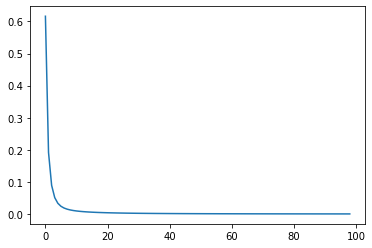

In [8]:
plt.plot(S)

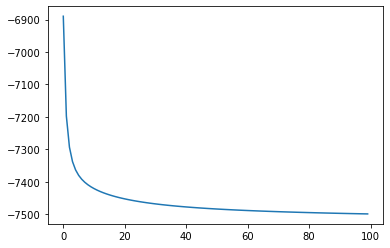

In [9]:
plt.plot(eta)

In [10]:
S[-1]

0.0003631242434730666

In [11]:
eta

array([-6889.51901132, -7197.56000536, -7293.42609151, -7338.10914215,
       -7363.65954239, -7380.40463733, -7392.49537508, -7401.84022476,
       -7409.41505402, -7415.7661394 , -7421.22347759, -7425.99941457,
       -7430.23791954, -7434.04092845, -7437.48327724, -7440.62160394,
       -7443.49989094, -7446.15304821, -7448.60930744, -7450.89186897,
       -7453.02006426, -7455.01019553, -7456.87615482, -7458.62988907,
       -7460.28175538, -7461.8407966 , -7463.31495802, -7464.71126001,
       -7466.03593707, -7467.29455105, -7468.49208421, -7469.63301636,
       -7470.72138934, -7471.76086135, -7472.75475295, -7473.70608631,
       -7474.61761891, -7475.49187252, -7476.33115843, -7477.13759929,
       -7477.91314828, -7478.65960585, -7479.37863459, -7480.07177223,
       -7480.7404432 , -7481.38596901, -7482.0095773 , -7482.61241016,
       -7483.19553136, -7483.75993304, -7484.30654157, -7484.83622294,
       -7485.34978758, -7485.84799472, -7486.3315564 , -7486.80114102,
      

In [12]:
eta_adj = eta - eta[-1]

In [13]:
eta_adj

array([6.09880989e+02, 3.01839995e+02, 2.05973909e+02, 1.61290858e+02,
       1.35740458e+02, 1.18995363e+02, 1.06904625e+02, 9.75597754e+01,
       8.99849461e+01, 8.36338607e+01, 7.81765226e+01, 7.34005856e+01,
       6.91620806e+01, 6.53590717e+01, 6.19167229e+01, 5.87783962e+01,
       5.59001092e+01, 5.32469519e+01, 5.07906927e+01, 4.85081312e+01,
       4.63799359e+01, 4.43898046e+01, 4.25238453e+01, 4.07701111e+01,
       3.91182448e+01, 3.75592035e+01, 3.60850421e+01, 3.46887401e+01,
       3.33640631e+01, 3.21054491e+01, 3.09079159e+01, 2.97669838e+01,
       2.86786108e+01, 2.76391388e+01, 2.66452472e+01, 2.56939138e+01,
       2.47823812e+01, 2.39081276e+01, 2.30688417e+01, 2.22624008e+01,
       2.14868519e+01, 2.07403943e+01, 2.00213655e+01, 1.93282279e+01,
       1.86595569e+01, 1.80140311e+01, 1.73904228e+01, 1.67875900e+01,
       1.62044688e+01, 1.56400671e+01, 1.50934586e+01, 1.45637772e+01,
       1.40502126e+01, 1.35520054e+01, 1.30684437e+01, 1.25988591e+01,
      

In [14]:
# save csv files

np.savetxt('elevation csv files/eta_exp_13.csv', eta_adj, delimiter = ',')
np.savetxt('alpha csv files/alpha_exp_13.csv', alpha, delimiter = ',')